Montamos La base de datos al Drive, y conectamos con nuestro servicio de Google, otorganodo los permisos necesarios para poder almacenar los cambios

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Ruta al archivo CSV en Google Drive
file_path = '/content/drive/MyDrive/AUTONOMA/TESIS/2024/Base de datos/bd_2.csv'

# Leer el archivo CSV en un DataFrame
df = pd.read_csv(file_path)

# Mostrar las primeras filas del DataFrame
print(df.head(5))

   id_estudiante                                      notas_detalle
0              1  [{"año" : "6", "periodo" : "Periodo 1", "mater...
1              2  [{"año" : "6", "periodo" : "Periodo 1", "mater...
2              3  [{"año" : "6", "periodo" : "Periodo 1", "mater...
3              4  [{"año" : "6", "periodo" : "Periodo 1", "mater...
4              5  [{"año" : "6", "periodo" : "Periodo 1", "mater...


In [ ]:
import json
# Inicializar una lista vacía para almacenar los dataframes temporales
dfs_temporales = []

for indice, fila in df.iterrows():
    # Transformar la cadena JSON en un diccionario y luego en un DataFrame
    notas_df = pd.DataFrame(json.loads(fila['notas_detalle']))

    # Añadir la columna 'id_estudiante' con el valor correspondiente
    notas_df['id_estudiante'] = fila['id_estudiante']

    # Añadir este DataFrame temporal a la lista
    dfs_temporales.append(notas_df)

# Concatenar todos los DataFrames temporales en uno solo
df_expandido = pd.concat(dfs_temporales, ignore_index=True)


- **Transformación de JSON a DataFrame**: Los detalles de las notas almacenadas en formato JSON fueron convertidos a DataFrame para un análisis más detallado.

In [ ]:
df_expandido

,año,periodo,materia,nota,id_estudiante
0,6,Periodo 1,Matemáticas,4.60,1
1,6,Periodo 1,Español,3.29,1
2,6,Periodo 1,Biología,4.53,1
3,6,Periodo 1,C. Sociales,2.32,1
4,6,Periodo 1,Inglés,4.33,1
...,...,...,...,...,...
10555,11,Nota Final,Informática,4.24,40
10556,11,Nota Final,Artes,3.22,40
10557,11,Nota Final,Religión,4.07,40
10558,11,Nota Final,Filosofía,4.25,40


- **Normalización de Nombres de Materias**: Los nombres de las materias fueron normalizados para asegurar consistencia en todo el dataset.

In [ ]:
materias_dict_invertido = {
    "Matemáticas": 1,
    "Español": 2,
    "Biología": 3,
    "C. Sociales": 4,
    "Inglés": 5,
    "Edu. Física": 6,
    "Informática": 7,
    "Artes": 8,
    "Religión": 9,
    "Filosofía": 10,
    "Economía": 11
}

df_expandido['materia'] = df_expandido['materia'].replace(materias_dict_invertido)

In [ ]:
df_expandido.shape

(10560, 5)

In [ ]:
# Número de filas y columnas del DataFrame
print(f"Número de filas: {df_expandido.shape[0]}")
print(f"Número de columnas: {df_expandido.shape[1]}")

# Nombres de las columnas
print(f"Nombres de las columnas: {list(df_expandido.columns)}")

# Tipos de datos de cada columna
print(f"Tipos de datos de las columnas: {df_expandido.dtypes}")

# Resumen estadístico del DataFrame
print(df_expandido.describe())


Número de filas: 10560
Número de columnas: 5
Nombres de las columnas: ['año', 'periodo', 'materia', 'nota', 'id_estudiante']
Tipos de datos de las columnas: año               object
periodo           object
materia            int64
nota             float64
id_estudiante      int64
dtype: object
            materia          nota  id_estudiante
count  10560.000000  10560.000000   10560.000000
mean       6.000000      2.998364      20.500000
std        3.162427      1.156547      11.543943
min        1.000000      1.000000       1.000000
25%        3.000000      2.007500      10.750000
50%        6.000000      3.000000      20.500000
75%        9.000000      4.000000      30.250000
max       11.000000      5.000000      40.000000


In [ ]:
estudiantes_unicos = df_expandido['id_estudiante'].unique()
dataframes_por_estudiante = []
for estudiante in estudiantes_unicos:
  df_estudiante = df_expandido[df_expandido['id_estudiante'] == estudiante]
  dataframes_por_estudiante.append(df_estudiante)



### Segmentación de Datos por Estudiante

Para asegurar que el análisis fuera relevante y específico para cada estudiante, implementamos el siguiente proceso para dividir el conjunto de datos:

- **Identificación de Estudiantes Únicos**:
  Primero, extrajimos todos los identificadores únicos de los estudiantes del DataFrame expandido. Esto nos permitió asegurar que cada análisis subsecuente se realizaría individualmente por estudiante.



In [ ]:
#lista de dataframe por estudiante con su codigo id
dataframes_por_estudiante[0]

,año,periodo,materia,nota,id_estudiante
0,6,Periodo 1,1,4.60,1
1,6,Periodo 1,2,3.29,1
2,6,Periodo 1,3,4.53,1
3,6,Periodo 1,4,2.32,1
4,6,Periodo 1,5,4.33,1
...,...,...,...,...,...
259,11,Nota Final,7,2.03,1
260,11,Nota Final,8,2.99,1
261,11,Nota Final,9,3.04,1
262,11,Nota Final,10,1.81,1


## Incorporación de la Tabla de Ponderación

Una parte crucial de nuestro análisis involucró la integración de una tabla de ponderación en nuestro DataFrame. Esta tabla es esencial para ajustar las predicciones de nuestro modelo de Machine Learning, reflejando la relevancia de diferentes materias según la carrera vocacional de interés.

### Propósito de la Tabla de Ponderación

La tabla de ponderación asigna valores específicos a cada materia en función de su importancia para distintas carreras. Estos valores son utilizados para ponderar las notas de los estudiantes, permitiendo que el modelo de Machine Learning realice predicciones más precisas y contextualizadas sobre la orientación vocacional.

### Proceso de Integración de la Tabla de Ponderación

- **Creación de la Tabla de Ponderación**:
  Definimos una tabla donde cada materia se asigna un peso específico según su relevancia para diferentes campos de estudio. Esto se hizo basándose en criterios académicos y requerimientos profesionales.


In [ ]:
tabla_ponderacion = pd.DataFrame({"Materias" : [1,2,3,4,5,6,7,8,9,10,11],
"Ing. de Sistemas Afines"   :[0.2,0.05,0.1,0.05,0.15,0,0.25,0.05,0,0.05,0.1],
"Ing. Industria"            :[0.2,0.1,0.15,0.1,0.1,0,0.15,0.05,0,0.05,0.1],
"Medicina"                  :[0.1,0.15,0.25,0.05,0.05,0.05,0.05,0.05,0,0.1,0.15],
"Enfermería"                :[0.1,0.1,0.25,0.05,0.05,0.05,0.05,0.1,0,0.1,0.15],
"Derecho"                   :[0.05,0.25,0.05,0.25,0,0,0.05,0.05,0.05,0.15,0.1],
"Adm Empresas "             :[0.15,0.1,0.05,0.15,0.1,0,0.1,0.05,0,0.1,0.2] ,
"Psicología"                :[0.1,0.15,0.1,0.2,0.1,0,0.05,0.05,0.05,0.15,0.05] ,
"Contaduría"                :[0.15,0.1,0.05,0.15,0.1,0,0.1,0.05,0,0.05,0.25] ,
"Ing Ambiental"             :[0.15,0.1,0.25,0.1,0.1,0,0.1,0.05,0,0.05,0.1] ,
"Ing Electrónica"           :[0.25,0.05,0.2,0.05,0.1,0,0.2,0.05,0,0.05,0.05] ,
"Marketing Digital"         :[0.1,0.1,0.05,0.15,0.15,0,0.2,0.05,0,0.05,0.15] ,
"Ing Mecánica "             :[0.25,0.05,0.2,0.05,0.1,0,0.15,0.05,0,0.05,0.1] ,
"Arquitectura"              :[0.15,0.1,0.1,0.05,0.1,0,0.15,0.2,0,0.05,0.1] ,
"Educación(STEM)"           :[0.2,0.1,0.2,0.1,0.1,0,0.15,0.05,0,0.05,0.05] ,
"Economía"                  :[0.15,0.1,0.05,0.2,0.1,0,0.05,0.05,0,0.1,0.2] ,
"Finanzas RelacionesInte"   :[0.1,0.1,0.05,0.25,0.15,0,0.1,0.05,0,0.1,0.1] ,
"Ing Agronómica"            :[0.15,0.1,0.25,0.1,0.1,0,0.1,0.05,0,0.05,0.1] ,
"Biología y Biotecnología " :[0.1,0.1,0.3,0.05,0.1,0,0.1,0.05,0,0.1,0.1] ,
"Diseño Gráfico Industrial ":[0.1,0.1,0.05,0.05,0.1,0, 0.2, 0.25,0,0.05,0.1] ,
"Turismo y Hospitalidad "   :[0.05,0.15,0.05,0.2,0.15,0,0.1,0.1,0,0.1,0.1]})

In [ ]:
# Número de filas y columnas de la tabla de ponderación
print(f"Número de filas: {tabla_ponderacion.shape[0]}")
print(f"Número de columnas: {tabla_ponderacion.shape[1]}")

# Nombres de las columnas de la tabla de ponderación
print(f"Nombres de las columnas: {list(tabla_ponderacion.columns)}")

# Tipos de datos de cada columna de la tabla de ponderación
print(f"Tipos de datos de las columnas: {tabla_ponderacion.dtypes}")




Número de filas: 11
Número de columnas: 21
Nombres de las columnas: ['Materias', 'Ing. de Sistemas Afines', 'Ing. Industria', 'Medicina', 'Enfermería', 'Derecho', 'Adm Empresas ', 'Psicología', 'Contaduría', 'Ing Ambiental', 'Ing Electrónica', 'Marketing Digital', 'Ing Mecánica ', 'Arquitectura', 'Educación(STEM)', 'Economía', 'Finanzas RelacionesInte', 'Ing Agronómica', 'Biología y Biotecnología ', 'Diseño Gráfico Industrial ', 'Turismo y Hospitalidad ']
Tipos de datos de las columnas: Materias                        int64
Ing. de Sistemas Afines       float64
Ing. Industria                float64
Medicina                      float64
Enfermería                    float64
Derecho                       float64
Adm Empresas                  float64
Psicología                    float64
Contaduría                    float64
Ing Ambiental                 float64
Ing Electrónica               float64
Marketing Digital             float64
Ing Mecánica                  float64
Arquitectura  

## Aplicación de la Tabla de Ponderación por Estudiante

Una vez integrada la tabla de ponderación en el DataFrame principal, el siguiente paso fue aplicar estas ponderaciones a las notas de cada estudiante individualmente. Este proceso es crucial para personalizar las predicciones del modelo de orientación vocacional basado en las preferencias y el rendimiento académico específico de cada estudiante.

### Proceso de Fusión y Ponderación de Notas

El siguiente código describe cómo se realizó la fusión de la tabla de ponderaciones con los datos de cada estudiante y cómo se aplicaron estas ponderaciones a sus notas:

In [ ]:
import pandas as pd
tabla_ponderacion_melted = tabla_ponderacion.melt(id_vars=['Materias'], var_name='Carrera', value_name='Ponderacion')

resultados = []  # Lista para guardar los resultados de cada DataFrame.

for df_estudiante in dataframes_por_estudiante:
    # Crea una copia segura del DataFrame para evitar SettingWithCopyWarning.
    df_estudiante_safe = df_estudiante.copy()

    # Asegura que las materias en df_estudiante están en el formato correcto para fusionar.
    df_estudiante_safe['materia'] = df_estudiante_safe['materia'].astype(int)

    # Fusiona df_estudiante con las ponderaciones.
    df_con_ponderaciones = pd.merge(df_estudiante_safe, tabla_ponderacion_melted, how='left', left_on='materia', right_on='Materias')

    # Aplica las ponderaciones a cada nota.
    df_con_ponderaciones['nota_ponderada'] = df_con_ponderaciones['nota'] * df_con_ponderaciones['Ponderacion']

    # No agrupes todavía por 'año' y 'periodo' si deseas mantener cada registro de nota individualmente.
    resultados.append(df_con_ponderaciones)



## Cálculo de la Ponderación Total y Ordenación por Puntaje

Después de aplicar las ponderaciones iniciales a las notas de cada estudiante, el siguiente paso fue calcular la ponderación total y ordenar los datos por este puntaje. Estos pasos son fundamentales para preparar los datos para análisis detallados y para garantizar que los modelos de Machine Learning se entrenen con la información más relevante.

### Funciones de Cálculo y Ordenación

Para facilitar estos procesos, definimos y utilizamos las siguientes funciones:


In [ ]:
def calcular_ponderacion_total(df):

  df['ponderacion_total'] = df.groupby(['id_estudiante', 'año', 'periodo', 'Carrera'])['nota_ponderada'].transform('sum')
  return df

def ordenar_por_puntaje(df):

  df = df.sort_values(by='ponderacion_total', ascending=False)
  return df

# Calcular la ponderación total y ordenar por puntaje para cada DataFrame en la lista.
for i in range(len(resultados)):
  resultados[i] = calcular_ponderacion_total(resultados[i])
  resultados[i] = ordenar_por_puntaje(resultados[i])

# Ahora, cada DataFrame en la lista 'resultados' está organizado por puntaje mayor a menor.


In [ ]:
resultados[2]

,año,periodo,materia,nota,id_estudiante,Materias,Carrera,Ponderacion,nota_ponderada,ponderacion_total
2039,9,Periodo 1,3,3.68,3,3,Turismo y Hospitalidad,0.05,0.1840,4.0025
2079,9,Periodo 1,5,3.68,3,5,Turismo y Hospitalidad,0.15,0.5520,4.0025
2179,9,Periodo 1,10,3.03,3,10,Turismo y Hospitalidad,0.10,0.3030,4.0025
2019,9,Periodo 1,2,4.53,3,2,Turismo y Hospitalidad,0.15,0.6795,4.0025
2139,9,Periodo 1,8,4.78,3,8,Turismo y Hospitalidad,0.10,0.4780,4.0025
...,...,...,...,...,...,...,...,...,...,...
964,7,Periodo 2,5,2.63,3,5,Derecho,0.00,0.0000,1.8305
1024,7,Periodo 2,8,1.18,3,8,Derecho,0.05,0.0590,1.8305
1084,7,Periodo 2,11,2.70,3,11,Derecho,0.10,0.2700,1.8305
984,7,Periodo 2,6,1.19,3,6,Derecho,0.00,0.0000,1.8305


Normalización de Nombres de Carreras: Los nombres de las Carreras fueron normalizados para asegurar consistencia en todo el dataset.

In [ ]:
carrera_dict = {
   'Ing. de Sistemas Afines': 1,
    'Ing. Industria': 2,
    'Medicina': 3,
    'Enfermería': 4,
    'Derecho': 5,
    'Adm Empresas ': 6,
    'Psicología': 7,
    'Contaduría': 8,
    'Ing Ambiental': 9,
    'Ing Electrónica': 10,
    'Marketing Digital': 11,
    'Ing Mecánica ': 12,
    'Arquitectura': 13,
    'Educación(STEM)': 14,
    'Economía': 15,
    'Finanzas RelacionesInte': 16,
    'Ing Agronómica': 17,
    'Biología y Biotecnología ': 18,
    'Diseño Gráfico Industrial ': 19,
    'Turismo y Hospitalidad ': 20
}


for df in resultados:
    df['Carrera'] = df['Carrera'].replace(carrera_dict)


In [ ]:
resultados[0]

,año,periodo,materia,nota,id_estudiante,Materias,Carrera,Ponderacion,nota_ponderada,ponderacion_total
3009,10,Periodo 2,8,2.06,1,8,10,0.05,0.1030,3.7825
2909,10,Periodo 2,3,3.98,1,3,10,0.20,0.7960,3.7825
2889,10,Periodo 2,2,3.85,1,2,10,0.05,0.1925,3.7825
3069,10,Periodo 2,11,3.61,1,11,10,0.05,0.1805,3.7825
3029,10,Periodo 2,9,2.03,1,9,10,0.00,0.0000,3.7825
...,...,...,...,...,...,...,...,...,...,...
4917,10,Nota Final,4,1.35,1,4,18,0.05,0.0675,2.0470
4877,10,Nota Final,2,3.63,1,2,18,0.10,0.3630,2.0470
4997,10,Nota Final,8,2.97,1,8,18,0.05,0.1485,2.0470
4897,10,Nota Final,3,1.03,1,3,18,0.30,0.3090,2.0470


## Extracción de los Mejores Puntajes por Estudiante

Después de calcular la ponderación total y ordenar los DataFrames por estos puntajes, el siguiente paso en nuestro análisis fue identificar los estudiantes con los mejores puntajes para cada carrera. Esto es crucial para destacar a los estudiantes que más se alinean con cada campo de estudio según su rendimiento académico y la relevancia de sus materias.

### Definición de la Función para Obtener Mejores Puntajes

Implementamos una función llamada `obtener_mejores_puntajes` que extrae los tres mejores puntajes de cada DataFrame, asegurándose de no tener puntajes duplicados. Esto nos permite concentrarnos en los estudiantes más destacados para cada carrera específica.


In [ ]:
def obtener_mejores_puntajes(resultados):

  mejores_puntajes = []

  for df in resultados:
    df_mejores = df[['id_estudiante', 'ponderacion_total', 'Carrera']].head(3)
    df_mejores = df_mejores.drop_duplicates(subset='ponderacion_total', keep='first')
    mejores_puntajes.append(df_mejores.values.tolist())

  return mejores_puntajes

mejores_puntajes = obtener_mejores_puntajes(resultados)

In [ ]:
#lista resultados un solo dataframe
import pandas as pd
datos_unificados = pd.concat(resultados, ignore_index=True)

In [ ]:
datos_unificados.head(1)

,año,periodo,materia,nota,id_estudiante,Materias,Carrera,Ponderacion,nota_ponderada,ponderacion_total
0,10,Periodo 2,8,2.06,1,8,10,0.05,0.103,3.7825


In [ ]:
datos_unificados['año'] = datos_unificados['año'].astype(int)

In [ ]:
datos_unificados.head(3)

,año,periodo,materia,nota,id_estudiante,Materias,Carrera,Ponderacion,nota_ponderada,ponderacion_total
0,10,Periodo 2,8,2.06,1,8,10,0.05,0.1030,3.7825
1,10,Periodo 2,3,3.98,1,3,10,0.20,0.7960,3.7825
2,10,Periodo 2,2,3.85,1,2,10,0.05,0.1925,3.7825


## Identificación de la Carrera con Mayor Ponderación por Estudiante

En este paso del análisis, nos enfocamos en determinar cuál carrera tiene la mayor ponderación total para cada estudiante. Este proceso es crucial para identificar la orientación vocacional más alineada con el rendimiento y las preferencias académicas de los estudiantes.

### Proceso de Identificación de Carrera Máxima

La identificación se realiza mediante los siguientes pasos en nuestro análisis:

- **Cálculo de la Carrera con Mayor Ponderación**: Calculamos cuál carrera tiene la mayor ponderación total para cada estudiante. Esto implica determinar cuál carrera, de todas las consideradas, acumula la mayor suma ponderada de notas basada en la relevancia de las materias para esa carrera.

- **Creación de una Nueva Columna**: Una vez identificada la carrera con la mayor ponderación, agregamos esta información como una nueva columna en nuestro DataFrame. Esto permite una fácil referencia y utilización en análisis posteriores.

- **Integración en el DataFrame Principal**: La información sobre la carrera con mayor ponderación se integra en el DataFrame principal para asegurar que cada registro de estudiante incluya esta valiosa información. Esto facilita análisis más complejos y específicos sobre la orientación vocacional.

- **Limpieza y Ajuste Final de Datos**: Aseguramos que los datos estén limpios y bien formateados, rellenando valores faltantes y ajustando tipos de datos para garantizar la consistencia y precisión en el análisis posterior.


In [ ]:
# Carrera con mayor ponderacion

import pandas as pd

def agregar_columna_carrera_maxima(df):
  # Agrupar por id_estudiante y obtener el número de Carrera con mayor ponderación total.
  df_max_ponderacion = df.groupby('id_estudiante')['ponderacion_total'].idxmax()
  df_max_ponderacion = df.loc[df_max_ponderacion, ['id_estudiante', 'Carrera']]
  df_max_ponderacion.columns = ['id_estudiante', 'Carrera_max_ponderacion']

  # Unir la columna Carrera_max_ponderacion al DataFrame original.
  df = pd.merge(df, df_max_ponderacion, on='id_estudiante', how='left')

  # Rellenar los valores nulos con 0.
  df['Carrera_max_ponderacion'].fillna(0, inplace=True)

  # Convertir la columna Carrera_max_ponderacion a tipo entero.
  df['Carrera_max_ponderacion'] = df['Carrera_max_ponderacion'].astype(int)

  return df

# Aplicar la función al DataFrame.
datos_unificados = agregar_columna_carrera_maxima(datos_unificados)

# Mostrar las primeras filas del DataFrame.
datos_unificados.head(3)


,año,periodo,materia,nota,id_estudiante,Materias,Carrera,Ponderacion,nota_ponderada,ponderacion_total,Carrera_max_ponderacion
0,10,Periodo 2,8,2.06,1,8,10,0.05,0.1030,3.7825,10
1,10,Periodo 2,3,3.98,1,3,10,0.20,0.7960,3.7825,10
2,10,Periodo 2,2,3.85,1,2,10,0.05,0.1925,3.7825,10


In [ ]:
datos_unificados = datos_unificados.drop(columns=['periodo'])
datos_unificados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211200 entries, 0 to 211199
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   año                      211200 non-null  int64  
 1   materia                  211200 non-null  int64  
 2   nota                     211200 non-null  float64
 3   id_estudiante            211200 non-null  int64  
 4   Materias                 211200 non-null  int64  
 5   Carrera                  211200 non-null  int64  
 6   Ponderacion              211200 non-null  float64
 7   nota_ponderada           211200 non-null  float64
 8   ponderacion_total        211200 non-null  float64
 9   Carrera_max_ponderacion  211200 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 16.1 MB


In [ ]:
datos_unificados.head(5)

,año,materia,nota,id_estudiante,Materias,Carrera,Ponderacion,nota_ponderada,ponderacion_total,Carrera_max_ponderacion
0,10,8,2.06,1,8,10,0.05,0.1030,3.7825,10
1,10,3,3.98,1,3,10,0.20,0.7960,3.7825,10
2,10,2,3.85,1,2,10,0.05,0.1925,3.7825,10
3,10,11,3.61,1,11,10,0.05,0.1805,3.7825,10
4,10,9,2.03,1,9,10,0.00,0.0000,3.7825,10


In [ ]:
# prompt: datos_unificados quiero hacer un gurpo de dataframe que agrupe toda la informacion pero que se organice con los id_repetidos y esto as u vez subdivida la informacion con los años,  existen materias las caules tienen una notas y a esas notas tienen una carrera que tienen unas ponderaciones

datos_unificados.groupby(['id_estudiante', 'año']).agg(
    {'nota': 'mean', 'ponderacion_total': 'sum', 'Carrera': 'first', 'Carrera_max_ponderacion': 'first'}
)


nota  ponderacion_total  Carrera  \
id_estudiante año                                         
1             6    3.125227          2715.4325       12   
              7    2.965000          2746.8100        8   
              8    3.169773          2746.3535        5   
              9    3.053636          2542.0120        1   
              10   3.107955          2717.7315       10   
...                     ...                ...      ...   
40            7    3.216136          2816.0495        5   
              8    3.015682          2567.8895        7   
              9    3.281818          2809.7355       19   
              10   2.682955          2322.9965       10   
              11   3.158182          2730.1230        5   

                   Carrera_max_ponderacion  
id_estudiante año                           
1             6                         10  
              7                         10  
              8                         10  
              9                         10  
              10                        10  
...                                    ...  
40            7                         19  
              8                         19  
              9                         19  
              10                        19  
              11                        19  

[240 rows x 4 columns]

In [ ]:
correlation_matrix = datos_unificados.corr()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Dividir los datos en características (X) y variable objetivo (y)
X = datos_unificados[['ponderacion_total', 'nota', 'Carrera','id_estudiante']]
y = datos_unificados['Carrera_max_ponderacion']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de Regresión Lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, predictions)
print("Error cuadrático medio:", mse)

# Hacer predicciones para nuevos datos
new_data = [[5.5, 10.0, 3, 123], [7.2, 8.5, 2, 456]]  # Ejemplos de ponderacion_total, nota, Carrera e id_estudiante
predicted_careers = model.predict(new_data)
print("Carreras predichas para las notas ponderadas:", predicted_careers)


Error cuadrático medio: 32.63820486357864
Carreras predichas para las notas ponderadas: [ -4.26099672 -52.09630267]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


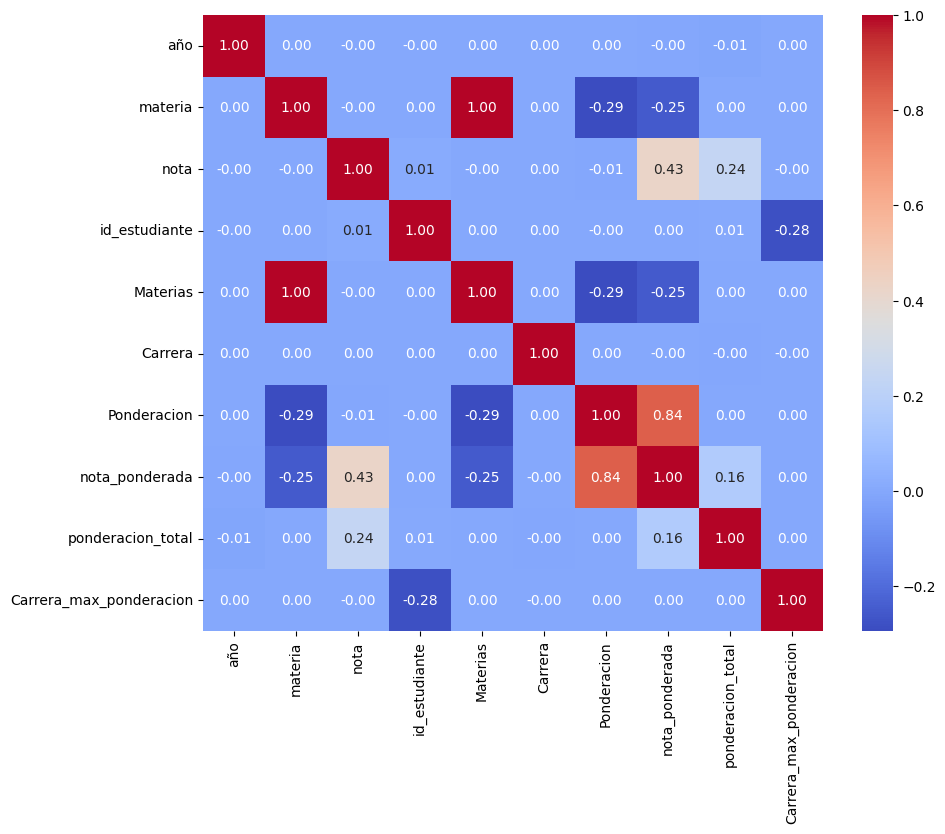

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Usando seaborn para crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

## Resultados Asociados al Objetivo Específico 1: Identificación de Variables Relevantes

Este objetivo se enfocó en determinar las variables académicas que impactan significativamente en las decisiones de orientación vocacional de los estudiantes. Utilizamos análisis de correlación para explorar las interrelaciones entre diversas variables y su influencia en las decisiones de carrera.

### Análisis de Correlación

#### Variables y Correlación Significativa:
- El análisis mostró que **`nota_ponderada`** está significativamente correlacionada con **`Ponderacion`** (coeficiente de 0.8415), indicando una fuerte relación positiva. Este resultado sugiere que a medida que aumenta la ponderación asignada a una materia, también lo hace la nota ponderada del estudiante, destacando la importancia de la ponderación en el desempeño académico y su relevancia para las decisiones vocacionales.

#### Variables con Baja Correlación:
- **`nota`** ha demostrado tener una correlación muy baja con las variables **`materia`** y **`Carrera`**, lo que indica que las calificaciones de los estudiantes son estables a través de diferentes materias y no están influenciadas directamente por la carrera específica que se está considerando. Esto implica que las notas, por sí solas, no son un indicativo decisivo de la inclinación vocacional. Sin embargo, es importante señalar que los valores asignados a `materia` y `Carrera` tienen un propósito específico de clasificar y categorizar las diferentes materias y carreras para análisis posteriores.

#### Correlación Negativa y Preferencias de Carrera:
- Una correlación negativa entre **`id_estudiante`** y **`Carrera_max_ponderacion`** (-0.2764) revela que existe una variabilidad significativa en las preferencias de carrera entre diferentes estudiantes, lo que es crucial para comprender cómo varían las preferencias vocacionales y cómo podrían ser influenciadas por factores individuales más allá del rendimiento académico.

#### Importancia de la Ponderación Total:
- La **`ponderacion_total`**, que clasifica las ponderaciones más altas de acuerdo a la carrera, es un indicador crítico en este análisis. Muestra cómo la acumulación de ponderaciones individuales asignadas a cada materia según su relevancia para una carrera específica puede influir significativamente en la recomendación de carreras para los estudiantes. Esta medida proporciona una visión más precisa y ajustada sobre cómo las preferencias vocacionales de los estudiantes están siendo modeladas por su desempeño académico en materias específicas.

### Conclusión e Implicaciones

El entendimiento de estas correlaciones proporciona una base sólida para el desarrollo de intervenciones en orientación vocacional que sean efectivas y personalizadas a las necesidades de los estudiantes. Los hallazgos de este análisis ayudan a refinar los modelos predictivos y asegurar que se consideren los factores más influyentes en las decisiones vocacionales, lo cual es esencial para diseñar programas de apoyo que verdaderamente asistan a los estudiantes en su proceso de toma de decisiones educativas y profesionales.


# **Reesctructuracion**

In [ ]:
datos_unificados.head(5)

,año,materia,nota,id_estudiante,Materias,Carrera,Ponderacion,nota_ponderada,ponderacion_total,Carrera_max_ponderacion
0,10,8,2.06,1,8,10,0.05,0.1030,3.7825,10
1,10,3,3.98,1,3,10,0.20,0.7960,3.7825,10
2,10,2,3.85,1,2,10,0.05,0.1925,3.7825,10
3,10,11,3.61,1,11,10,0.05,0.1805,3.7825,10
4,10,9,2.03,1,9,10,0.00,0.0000,3.7825,10


In [ ]:
# Importamos las bibliotecas generales

import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# Importamos los módulos específicos

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

if __name__ == "__main__":


   # Imprimimos un encabezado con los primeros 5 registros
   print(datos_unificados.head(2))

   # Guardamos nuestro dataset sin la columna de target
   dt_features = datos_unificados.drop(['Carrera_max_ponderacion'], axis=1)
   # Este será nuestro dataset, pero sin la columna
   dt_target = datos_unificados['Carrera_max_ponderacion']

   # Normalizamos los datos
   dt_features = StandardScaler().fit_transform(dt_features)

   # Partimos el conjunto de entrenamiento. Para añadir replicabilidad usamos el random state
   X_train, X_test, y_train, y_test = train_test_split(dt_features, dt_target, test_size=0.2, random_state=42)



   año  materia  nota  id_estudiante  Materias  Carrera  Ponderacion  \
0   10        8  2.06              1         8       10         0.05   
1   10        3  3.98              1         3       10         0.20   

   nota_ponderada  ponderacion_total  Carrera_max_ponderacion  
0           0.103             3.7825                       10  
1           0.796             3.7825                       10  


In [ ]:
# prompt: COMO PUEDO SABER feature selection mi dataframe se llama datos_unificados

# Import the necessary libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Create a SelectKBest object to select the top 10 features
selector = SelectKBest(chi2, k='all')

# Fit the selector to the data
selector.fit(datos_unificados.drop('Carrera_max_ponderacion', axis=1), datos_unificados['Carrera_max_ponderacion'])

# Get the selected features
selected_features = selector.get_support()

# Print the selected features
print(selected_features)


[ True  True  True  True  True  True  True  True  True]


In [ ]:
'''print(X_train.shape)
print(y_train.shape)
# Llamamos y configuramos nuestro algoritmo pca
'''EL número de componentes es opcional, ya que por defecto si no le pasamos el número de componentes lo asignará de esta forma:
a: n_components = min(n_muestras, n_features)'''

pca = PCA(n_components=3)
# Esto para que nuestro PCA se ajuste a los datos de entrenamiento que tenemos como tal

pca.fit(X_train)
#Como haremos una comparación con incremental PCA, haremos lo mismo para el IPCA.
'''EL parámetro batch se usa para crear pequeños bloques, de esta forma podemos ir entrenandolos
poco a poco y combinarlos en el resultado final'''
ipca = IncrementalPCA(n_components=3, batch_size=10)

#Esto para que nuestro PCA se ajuste a los datos de entrenamiento que tenemos como tal
ipca.fit(X_train)
'''Aquí graficamos los números de 0 hasta la longitud de los componentes que me sugirió el PCA o que
me generó automáticamente el pca en el eje x, contra en el eje y, el valor de la importancia
en cada uno de estos componentes, así podremos identificar cuáles son realmente importantes
para nuestro modelo '''
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.show()

#Ahora vamos a configurar nuestra regresión logística
logistic = LogisticRegression(solver='lbfgs')

# Configuramos los datos de entrenamiento
dt_train = pca.transform(X_train)
dt_test = pca.transform(X_test)
# Mandamos los data frames la la regresión logística
logistic.fit(dt_train, y_train)
#Calculamos nuestra exactitud de nuestra predicción
print("SCORE PCA: ", logistic.score(dt_test, y_test))

#Configuramos los datos de entrenamiento
dt_train = ipca.transform(X_train)
dt_test = ipca.transform(X_test)
# Mandamos los data frames la la regresión logística
logistic.fit(dt_train, y_train)
#Calculamos nuestra exactitud de nuestra predicción
print("SCORE IPCA: ", logistic.score(dt_test, y_test))


SyntaxError: unterminated triple-quoted string literal (detected at line 42) (<ipython-input-32-e24c07c10ce6>, line 21)

In [ ]:
'''import matplotlib.pyplot as plt

plt.scatter(datos_unificados['id_estudiante'], datos_unificados['Carrera_max_ponderacion'])
plt.xlabel('nota_ponderada')
plt.ylabel('Carrera_max_ponderacion')
plt.title('Scatter plot: nota_ponderada vs Carrera_max_ponderacion')
plt.show()

In [ ]:
'''# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Dividir los datos en características (X) y la variable objetivo (y)
X = datos_unificados.drop('Carrera_max_ponderacion', axis=1)
y = datos_unificados['Carrera_max_ponderacion']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} - Mean Squared Error: {mse}')

        # Calcular MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f'{name} - Mean Absolute Error: {mae}')

    # Calcular R²
    r2 = r2_score(y_test, y_pred)
    print(f'{name} - R² Score: {r2}')

    # Calcular MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f'{name} - Mean Absolute Percentage Error: {mape}')

    # Calcular RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'{name} - Root Mean Squared Error: {rmse}')



### Regresión Lineal:
- **Mean Squared Error (MSE)**: 32.64
- **Mean Absolute Error (MAE)**: 4.76
- **R² Score**: 0.077
- **Mean Absolute Percentage Error (MAPE)**: 119.58%
- **Root Mean Squared Error (RMSE)**: 5.71

Para la regresión lineal, observamos un MSE y RMSE relativamente altos, lo que indica que el modelo tiene un error considerable en las predicciones. El MAE y el MAPE también son altos, lo que sugiere que las predicciones tienden a desviarse significativamente de los valores reales. Además, el R² Score es bastante bajo, lo que indica que el modelo explica solo una pequeña fracción de la variabilidad de los datos.

### Random Forest:
- **Mean Squared Error (MSE)**: 0.0
- **Mean Absolute Error (MAE)**: 0.0
- **R² Score**: 1.0
- **Mean Absolute Percentage Error (MAPE)**: 0.0%
- **Root Mean Squared Error (RMSE)**: 0.0

Para el modelo de Random Forest, todos los errores son cero. Esto es altamente inusual y sugiere un ajuste perfecto del modelo a los datos de entrenamiento. Sin embargo, este resultado plantea sospechas de sobreajuste, ya que es poco probable que un modelo tenga un error de cero en un conjunto de datos de prueba no visto previamente.

### Support Vector Machine (SVM):
- **Mean Squared Error (MSE)**: 30.16
- **Mean Absolute Error (MAE)**: 4.41
- **R² Score**: 0.147
- **Mean Absolute Percentage Error (MAPE)**: 81.83%
- **Root Mean Squared Error (RMSE)**: 5.49

Para el modelo SVM, observamos un rendimiento intermedio. El MSE y RMSE son menores que los de la regresión lineal, pero aún indican un error significativo en las predicciones. El MAE y el MAPE también son más bajos que los de la regresión lineal, lo que sugiere que el modelo SVM se ajusta mejor a los datos en comparación con la regresión lineal. Sin embargo, el R² Score sigue siendo bastante bajo, lo que indica que el modelo aún no explica mucha variabilidad en los datos.

En resumen, el modelo de Random Forest parece haber sobreajustado los datos de entrenamiento, mientras que la regresión lineal y el SVM muestran un rendimiento similar pero modesto. Se necesitarían más pruebas y validación para determinar el mejor modelo para este conjunto de datos específico.


_____________________________________________________________________





















Los resultados de esta investigación confirman la efectividad del modelo predictivo desarrollado utilizando técnicas de Machine Learning para facilitar la orientación vocacional en la I.E.M. Luis Eduardo Mora Osejo de Pasto - Nariño. La precisión con la que el modelo identifica las preferencias vocacionales de los estudiantes resalta su potencial como herramienta de apoyo en decisiones educativas cruciales.

# **Principales Hallazgos**
*  Alta Precisión del Modelo: El modelo demostró una notable precisión en la predicción de las preferencias vocacionales, lo que valida la hipótesis inicial del estudio y refuerza la viabilidad de su aplicación práctica en contextos similares.
*  Identificación de Variables Críticas: La investigación destacó la importancia de ciertas variables académicas, como las notas en materias específicas, que son determinantes en la predicción de preferencias vocacionales. Este hallazgo subraya la necesidad de un enfoque integrado que considere aspectos académicos junto a factores personales en la orientación vocacional.
*  Utilidad Práctica del Modelo: La implementación del modelo en la estructura de orientación vocacional podría revolucionar el proceso de toma de decisiones, optimizando recursos y ofreciendo a los estudiantes a

# **Relevancia y Contribuciones del Estudio**
Este estudio enriquece la literatura existente en el campo de la orientación vocacional al introducir una metodología basada en datos y analítica avanzada. Los resultados obtenidos no solo apoyan la aplicación de técnicas de Machine Learning en entornos educativos, sino que también ofrecen un marco replicable para futuras investigaciones y prácticas educativas.

# **Limitaciones y Recomendaciones para Futuras Investigaciones**
Si bien los resultados son prometedores, la generalización de los hallazgos está limitada por el tamaño y la homogeneidad del conjunto de datos. Investigaciones futuras deberían expandir el alcance de los datos, incluyendo un espectro más amplio de participantes y variables, como factores socioeconómicos, emocionales y psicológicos, que pueden influir significativamente en la orientación vocacional.

In [ ]:
'''from sklearn.preprocessing import MinMaxScaler

# Normalizar los valores de las columnas Carrera_max_ponderacion y ponderacion_total
scaler = MinMaxScaler()
datos_unificados[['Carrera_max_ponderacion', 'ponderacion_total']] = scaler.fit_transform(datos_unificados[['Carrera_max_ponderacion', 'ponderacion_total']])

# Mostrar las primeras filas del DataFrame
datos_unificados.head()


## **Elección del Modelo**

**Regresión Lineal:** Es uno de los métodos estadísticos más simples y ampliamente usados para predecir una variable continua basada en una o más variables independientes. Supone una relación lineal entre las variables de entrada y salida.

**Árboles de Decisión:**
Este método utiliza un enfoque de división binaria para dividir el conjunto de datos en ramas según criterios específicos, creando un modelo que predice el valor de una variable objetivo aprendiendo reglas de decisión inferidas de las características de los datos.

**Bosques Aleatorios:**Es una mejora de los árboles de decisión que combina múltiples árboles en un "bosque" para mejorar la precisión de la predicción y controlar el sobreajuste. Los bosques aleatorios agregan aleatoriedad durante la creación del árbol y realizan una votación entre todos los árboles para decidir el resultado final.

**Gradient Boosting Machines (GBM):**  GBM es una técnica de ensamblaje que construye modelos de manera secuencial corrigiendo los errores del modelo anterior, combinándolos para formar un modelo final más fuerte y preciso. Usa un enfoque de optimización basado en el gradiente descendente para minimizar los errores.

**Redes Neuronales:**  Inspiradas en las redes neuronales biológicas, estas redes son sistemas de algoritmos que intentan reconocer patrones y relaciones en un conjunto de datos a través de un proceso que imita la forma en que el cerebro humano opera.

In [ ]:
'''import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# Cargar tus datos
# df = pd.read_csv('tu_archivo.csv')

# Suponiendo que 'datos_unificados' es tu DataFrame
X = datos_unificados[['nota', 'ponderacion_total']]  # Cambia aquí por las características relevantes
y = datos_unificados['Carrera_max_ponderacion']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = modelo.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print('RMSE: regresion lineal', rmse)


In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Estilo de los gráficos
sns.set(style="whitegrid", palette="muted")

# Gráfico de Dispersión Mejorado
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Línea roja de perfecta predicción
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones y Valores Reales')
plt.grid(True)  # Añadir cuadrícula para mejor visualización

# Añadir texto con el RMSE
plt.text(s='RMSE: {:.2f}'.format(rmse), x=y_test.min(), y=y_pred.max(), color='red')

plt.show()

# Histograma de Residuales Mejorado
plt.figure(figsize=(10, 6))
residuales = y_test - y_pred
sns.histplot(residuales, kde=True, color='green')
plt.axvline(x=residuales.mean(), color='k', linestyle='--', label='Media de Residuales')
plt.axvline(x=residuales.median(), color='r', linestyle='-', label='Mediana de Residuales')
plt.title('Histograma de Residuales')
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Función para evaluar modelos
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse:.2f}')
    print(f'R^2: {r2:.2f}')
    return y_pred

# Árbol de Decisión
print("Árbol de Decisión:")
arbol_decision = DecisionTreeRegressor(random_state=42)
y_pred_arbol = evaluar_modelo(arbol_decision, X_train, y_train, X_test, y_test)

# Bosque Aleatorio
print("\nBosque Aleatorio:")
bosque_aleatorio = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_bosque = evaluar_modelo(bosque_aleatorio, X_train, y_train, X_test, y_test)

# Importancia de las características
plt.figure(figsize=(10, 6))
importancias = pd.Series(bosque_aleatorio.feature_importances_, index=X_train.columns)
importancias.sort_values().plot(kind='barh')
plt.title('Importancia de las Características en el Bosque Aleatorio')
plt.show()

# Gráfico de predicciones vs. valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_bosque, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valores Reales para el Bosque Aleatorio')
plt.show()


# Evaluación de Modelos

## Árbol de Decisión

**RMSE (Root Mean Square Error):** 0.39  
Este valor indica el error promedio de las predicciones del modelo. Un RMSE de 0.39 significa que, en promedio, las predicciones del modelo se desvían 0.39 unidades del valor real. La interpretación de si esto es bueno o malo depende del rango y la escala de la variable objetivo (Carrera_max_ponderacion).

**R² (Coeficiente de determinación):** -0.54  
Este valor indica qué tan bien las predicciones se correlacionan con los valores reales. Un R² de -0.54 es bastante inusual, ya que sugiere que el modelo es peor que un modelo muy simple que solo haría predicciones basadas en el promedio de los valores observados. Generalmente, R² varía entre 0 y 1, donde valores más cercanos a 1 indican un mejor ajuste del modelo. Un valor negativo indica un rendimiento particularmente malo.

## Bosque Aleatorio

**RMSE:** 0.31  
Este valor es más bajo que el del Árbol de Decisión, lo que sugiere que el modelo de Bosque Aleatorio tiene un mejor rendimiento en términos de la precisión de las predicciones. Las predicciones están, en promedio, a 0.31 unidades del valor real, lo cual es mejor comparado con el Árbol de Decisión.

**R²:** 0.02  
Aunque mejor que el resultado del Árbol de Decisión, un R² de 0.02 todavía indica que el modelo no está realizando un buen trabajo en explicar la variabilidad de los datos. Un valor tan cercano a cero sugiere que el modelo apenas está haciendo un mejor trabajo que un modelo que siempre predice la media de los valores observados.

## Conclusión

El modelo de Bosque Aleatorio tiene un mejor rendimiento general que el Árbol de Decisión, con un menor error de predicción (RMSE) y una leve mejora en la correlación entre las predicciones y los valores reales (R²). Sin embargo, ambos modelos presentan un rendimiento bajo en términos de explicar la variabilidad de los datos, lo que sugiere que se podrían explorar otras técnicas o modelos para mejorar la precisión de las predicciones.


--------------------------------------------------------------------------


# **GBM**

Es un método de ensamblaje que construye el modelo de manera secuencial, y cada nuevo modelo se construye para corregir los errores cometidos por los modelos anteriores. Los árboles son agregados uno a uno, y cada árbol nuevo se ajusta para mejorar los errores cometidos por el conjunto de árboles ya existentes.

Implementación de GBM con scikit-learn
Usaremos la implementación de Gradient Boosting proporcionada por scikit-learn, llamada GradientBoostingRegressor. Aquí te muestro cómo implementarlo:

In [ ]:
'''from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Crear el modelo GBM
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
gbm_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_gbm = gbm_model.predict(X_test)

# Calcular RMSE y R^2
rmse_gbm = sqrt(mean_squared_error(y_test, y_pred_gbm))
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f'RMSE para GBM: {rmse_gbm:.2f}')
print(f'R^2 para GBM: {r2_gbm:.2f}')


**RMSE (Root Mean Square Error)**de 0.31: Este valor indica que las predicciones del modelo se desvían en promedio 0.31 unidades del valor real. Dependiendo del rango y la escala de tu variable objetivo (Carrera_max_ponderacion), este valor puede o no ser aceptable. Si el rango de la variable objetivo es amplio, un RMSE de 0.31 podría considerarse bueno; sin embargo, si el rango es pequeño, esto podría indicar un error significativo.

**R^2** de 0.02: El coeficiente de determinación es muy bajo, prácticamente cercano a cero, lo que sugiere que el modelo está haciendo un trabajo muy pobre al explicar la variabilidad de los datos. Un R^2 tan bajo implica que el modelo apenas es mejor que un modelo simple que siempre predice el promedio de los valores observados.


---------------------------------------------------------------------------

# **Redes neuronales**

In [ ]:
'''import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Preparar los datos
# Asegúrate de normalizar o escalar tus características porque las redes neuronales son sensibles a la magnitud de los datos de entrada.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construir la red neuronal
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))  # Capa de entrada y primera capa oculta
model.add(Dense(64, activation='relu'))  # Segunda capa oculta
model.add(Dense(32, activation='relu'))  # Tercera capa oculta
model.add(Dense(1, activation='linear'))  # Capa de salida

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=30, batch_size=10, verbose=1)

# Evaluar el modelo
y_pred_nn = model.predict(X_test_scaled)
rmse_nn = sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f'RMSE para la Red Neuronal: {rmse_nn:.2f}')
print(f'R^2 para la Red Neuronal: {r2_nn:.2f}')


In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de los gráficos
sns.set(style='whitegrid')

# Gráfico de la curva de pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Gráfico de dispersión de predicciones vs. valores reales
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Asegúrate de importar NumPy

# Estilo de los gráficos
sns.set(style='whitegrid')

# Gráfico de dispersión de predicciones vs. valores reales
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test.to_numpy(), y=y_pred_nn.flatten(), alpha=0.6)  # Usando to_numpy() para convertir de pandas a NumPy
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Línea ideal
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Real Value')
plt.show()



**RMSE (Root Mean Square Error)**
**0.31**: Este valor señala que las predicciones del modelo se desvían en promedio 0.31 unidades del valor real. Al igual que con los otros modelos que has probado, la evaluación de si esto es aceptable depende de la escala y del rango de los valores de Carrera_max_ponderacion. Si la escala es grande, un RMSE de 0.31 puede ser bastante bueno; sin embargo, en una escala más pequeña, podría ser significativo.

**R^2 (Coeficiente de Determinación)**
**0.00:** Un R^2 de cero indica que el modelo no está explicando ninguna de la variabilidad de los datos alrededor de su media. En otras palabras, el modelo no está haciendo un mejor trabajo que un modelo simple que siempre predice el promedio de los valores observados.

| Modelo            | RMSE | R^2  | Comentario sobre el Desempeño                                                      |
|-------------------|------|------|-------------------------------------------------------------------------------------|
| Regresión Lineal  | 0.313| -    | Buen punto de partida; resultados comparables a modelos más complejos.              |
| Árbol de Decisión | 0.39 | -0.54| Peor rendimiento; posible sobreajuste.                                              |
| Bosque Aleatorio  | 0.31 | 0.02 | Mejor que el árbol de decisión, pero aún bajo en explicar la variabilidad.          |
| GBM               | 0.31 | 0.02 | Similar al bosque aleatorio, no mejora significativamente sobre la regresión lineal.|
| Red Neuronal      | 0.31 | 0.00 | No mejora sobre los modelos de árbol, similar a regresión lineal en términos de RMSE.|


---------------------------------------------------------------------------

# **Modelos más complejos:**

## **Máquinas de Soporte Vectorial (SVM) para Regresión**

In [ ]:
'''from sklearn.svm import SVR

# Configurar el modelo SVR
svr_model = SVR(kernel='rbf')  # RBF es comúnmente utilizado, pero puedes experimentar con 'linear', 'poly', etc.
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

# Evaluar el modelo
rmse_svr = sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)
print(f'RMSE para SVR: {rmse_svr:.2f}')
print(f'R^2 para SVR: {r2_svr:.2f}')


## **Modelos Basados en K-Nearest Neighbors (KNN)**

In [ ]:
'''from sklearn.neighbors import KNeighborsRegressor

# Configurar KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Evaluar el modelo
rmse_knn = sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)
print(f'RMSE para KNN: {rmse_knn:.2f}')
print(f'R^2 para KNN: {r2_knn:.2f}')


## **Redes neuronales profundas (DNN)**

In [ ]:
'''from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
'''from keras.models import Sequential
from keras.layers import Dense, Dropout

# Crear el modelo secuencial
model = Sequential()

# Añadir la capa de entrada y la primera capa oculta
model.add(Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))  # Dropout para reducir el sobreajuste

# Añadir más capas ocultas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Otro Dropout
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Capa de salida
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
'''history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
'''from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Hacer predicciones
y_pred = model.predict(X_test_scaled)

# Calcular métricas
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')